# XDGMM Demo

In this notebook we demonstrate some of the funcitonality of the `XDGMM` class. We will borrow the example from the `AstroML` "Extreme Deconvolution" (XD) demo written by Jake VanderPlas [here](http://www.astroml.org/book_figures/chapter6/fig_XD_example.html#book-fig-chapter6-fig-xd-example), and:

* Use the `AstroML` implementation of the XD algorithm to model Jake's example heteroscedastic dataset with a Gaussian Mixture Model (GMM);  
* Show how we can select an appropriate number of GMM components using the Bayesian Information Criterion;
* Compare this with the result of a `scikit-learn` cross-validation analysis;
* Condition the GMM on a subset of the parameters, and draw samples from the resulting conditional PDF.

## Requirements

First, import the necessary packages.  All fitting will be done with the `AstroML` algorithm in this demo, so that the Bovy et al. algorthim does not need to be installed to run the code. However, we note that the Bovy et al. algorithm is, in general, significantly (ie several times) faster. We recommend you try each method on your dataset when using this class.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from xdgmm import XDGMM

from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import ShuffleSplit

from demo_plots import *

Next, generate some data to use for our fitting and plotting. This generates the same dataset as in the `AstroML` demo.

In [2]:
N = 2000
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

## Component Number Selection

We could fit this data directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way this can be determined is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score using the `bic_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will use this to test the performance of the model with n_components ranging from 1 to 10 and produce a figure to display the results. 

Note that due to the multiple fits, a BIC test may take a while to run, depending on your system.

In [3]:
# Instantiate an XDGMM model:
xdgmm = XDGMM()

# Define the range of component numbers, and get ready to compute the BIC for each one:
param_range = np.array([1,2,3,4,5,6,7,8,9,10])

# Loop over component numbers, fitting XDGMM model and computing the BIC:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X, Xerr, param_range)

N = 1 , BIC = 17315.9224389
N = 2 , BIC = 16130.5772176
N = 3 , BIC = 15886.9897856
N = 4 , BIC = 15852.280504
N = 5 , BIC = 15845.3876314
N = 6 , BIC = 15879.1549973
N = 7 , BIC = 15920.9246167
N = 8 , BIC = 15959.3579067
N = 9 , BIC = 15996.0533917
N = 10 , BIC = 16036.7408988


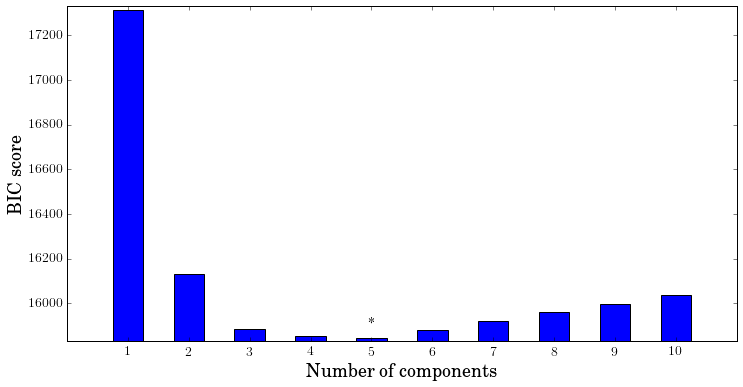

In [4]:
plot_bic(param_range, bic, optimal_n_comp)

### Cross-Validation

Another way to determine the number of components is to perform a cross-validation test using different numbers of components. Since this XDGMM class implements all the methods necessary to use `scikit-learn` cross-validation tools, we can use them to test the performance of the model with different numbers of components.

Here we do a cross-validation test using the same numbers of Gaussian components as in the BIC test above. As with the BIC test, this can be a slow process depending on your system due to the repeated fitting.

>One important thing to note is the trick used to pass errors to the scikit-learn methods. Normally for unsupervised learning you would only pass an `X` array, and not a "target" `y` array, to the validation_curve method. However, we need to pass an error array to our `xdgmm.fit` method, and `validation_curve` simply uses the `y` parameter as the second argument for the `fit` function. So, by treating the `Xerr` array as the "target" array, we can pass it to our fit function so that it can be used in fitting the data.

In [5]:
param_range = np.array([1,2,3,4,5,6,7,8,9,10])
shuffle_split = ShuffleSplit(len(X), 3, test_size=0.3)

train_scores,test_scores = validation_curve(xdgmm, X=X, y=Xerr, 
                                            param_name="n_components",
                                            param_range=param_range,
                                            n_jobs=3,
                                            cv=shuffle_split,
                                            verbose=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 12.6min finished


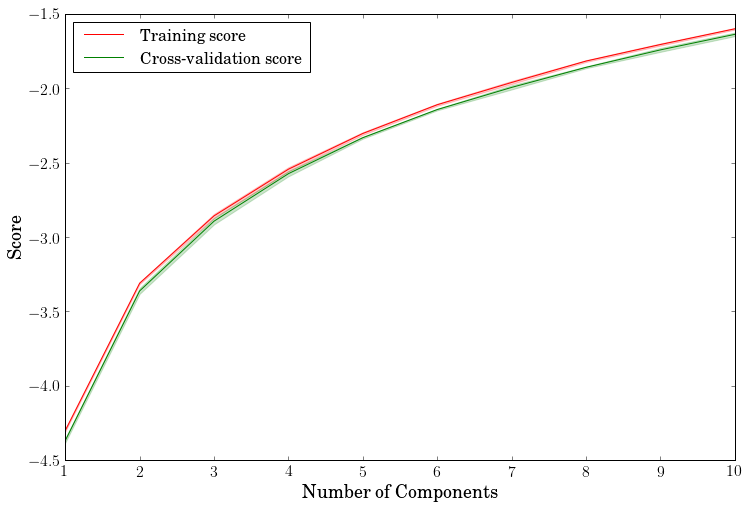

In [6]:
plot_val_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

We can see here that the cross-validation test prefers the maximum number of components (10) that we allowed for the model (and in fact, the score continues to rise as more components are added beyond 10). This is a result of the particular dataset being fit: the likelihood of the data being fit increases with more components, and there is enough structure to the data that even with a large number of Gaussians, the trained model continues to be a good predictor of new data.

However, increasing the number of components in the model rapidly causes the fit algorithm to become computationally expensive, especially for the `astroML` algorithm. While a model with a large number of components may be mathematically superior, in most cases the BIC seems to provide a way to find a model that is "good enough" to fit the data well, while also keeping the number of components at a value that keeps the computation of new fits reasonable.

Based on the BIC results, let's choose 5 components to model these data.

## Model Fitting

Now that we know the best number of components to use, we can fit the data. First set the number of components, then perform the fit.

In [7]:
xdgmm.n_components = optimal_n_comp
xdgmm = xdgmm.fit(X, Xerr)

## Saving to and Reading from a File

Since fitting the model, even one with only a few components, can be a lengthy process, it can save a lot of time to save the model after fitting so that the same model can be used in the future without the need to re-fit the data. This can be done by calling the `save_model()` function.

In [8]:
xdgmm.save_model('demo_model.fit')

Once the model is saved, it can be read into an XDGMM object using the `read_model()` function, or a new XDGMM object can be initialized directly from the saved model file. Note that if both a filename and model parameters are passed to the constructor, the parameters saved in the file will override those passed by the user.

In [9]:
# Read model into an existing XDGMM object
xdgmm.read_model('demo_model.fit')

# Initialize a new XDGMM object using the model
xdgmm2 = XDGMM(filename='demo_model.fit')

# Comparison --- the arrays should be the same.
print xdgmm.weights
print xdgmm2.weights

[ 0.16738107  0.22575904  0.23625154  0.25308684  0.11752151]
[ 0.16738107  0.22575904  0.23625154  0.25308684  0.11752151]


## Sampling from the Model

Now that we have a model that has been fit to the data, we can use it to sample data points. Here we sample 2000 points from the model and plot the "true" distribution of the data, the "observed" noisy data, the data generated by the model, and the 1-sigma Gaussian components in the model.

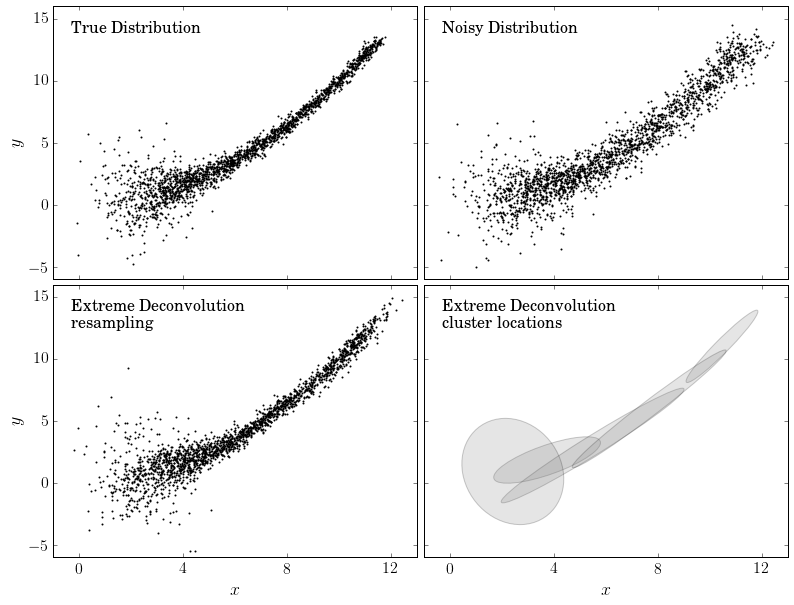

In [10]:
sample = xdgmm.sample(N)

plot_sample(x_true, y_true, x, y, sample, xdgmm)

## Conditioning the Model

One of the key advantages of our implementation of the XDGMM class is that it contains a method for producing a model for the conditional PDF $P(x | y)$ from the original GMM model for the joint PDF $P(x, y)$. The conditional PDF is also a GMM with the same number of components, but with adjusted weights, means and variance. This is useful for predicting new $x$ values given test $y$ values: we simply sample from the conditioned model.

For our example dataset, let's assume that we have measured the $y$ value to be $1.5\pm0.05$. We can produce a new model for $x$ that is conditioned on $y=1.5\pm0.05$, and use that to sample values of $x$. When `condition()` is called, we set all parameters that we do not want included in the conditioning to `NaN`. The model can be conditioned on values either with uncertainties or without; to condition without uncertainty either do not pass an error array, or set all the uncertainties equal to $0$. If provided, the uncertainties are interpreted as being Gaussian and uncorrelated, and thus providing a simple $P(y)$ to be combined with the joint PDF. 

In [11]:
cond_X = np.array([np.nan, 1.5])
cond_Xerr = np.array([0.0,0.05])
cond_xdgmm = xdgmm.condition(cond_X,cond_Xerr)

# Compare the conditioned model to the original:
print xdgmm.weights
print cond_xdgmm.weights
print "\n"
print xdgmm.mu
print cond_xdgmm.mu

[ 0.16738107  0.22575904  0.23625154  0.25308684  0.11752151]
[  2.97886640e-10   5.89417880e-01   2.20533994e-01   4.89898331e-02
   1.41058293e-01]


[[ 10.47659567  11.0151214 ]
 [  3.74215085   1.84467492]
 [  5.49529406   3.01374125]
 [  7.67327662   5.97528913]
 [  2.42152112   0.9184206 ]]
[[ 6.22958519]
 [ 3.47593941]
 [ 4.37668834]
 [ 4.94489608]
 [ 2.38359845]]


Note how the number of components in the conditioned model is the same as in the original joint model, but that the weights of the components have changed, and the mu array is now 1-dimensional (since $y$ has been conditioned out).

Below we plot the original Gaussian components in the $x-y$ plane, a blue line showing the condition $y=1.5$, and a red line showing the new conditional distribution for $x$ given $y=1.5\pm0.05$.

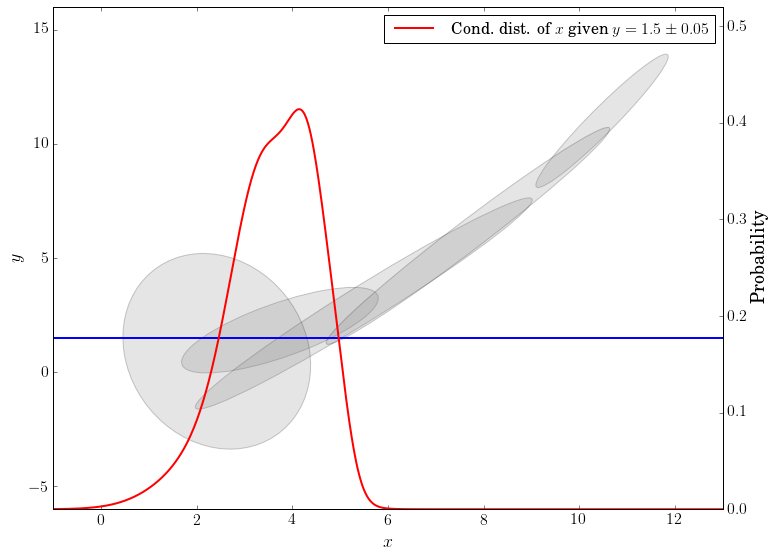

In [12]:
plot_cond_model(xdgmm, cond_xdgmm, 1.5)

If we sample 1000 points from this conditional distribution, we would get something like this:

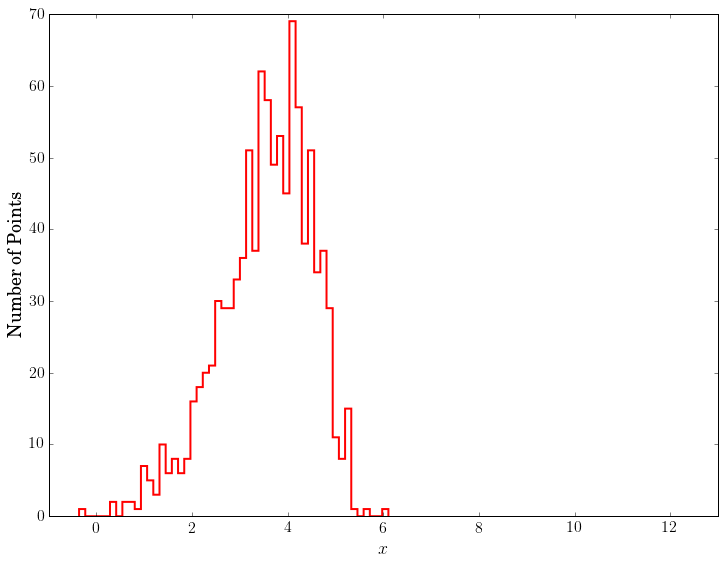

In [13]:
cond_sample = cond_xdgmm.sample(1000)
y = np.ones(1000)*1.5
plot_cond_sample(cond_sample,y)

## Conditional Prediction

As stated before, one potential use of a conditioned model is to create a "prediction engine" that can predict some parameters using an `XDGMM` model conditioned on known values of other parameters.

To demonstrate this, let's sample 1000 data points from our joint model to create a dataset to be compared with our predictions. Now, at the same $y$ values as this "observed" dataset, we'll condition the model on each $y$ value in turn, and draw a single predicted $x$ value. These predicted $x$'s should follow the same distribution as the observed $x$'s.

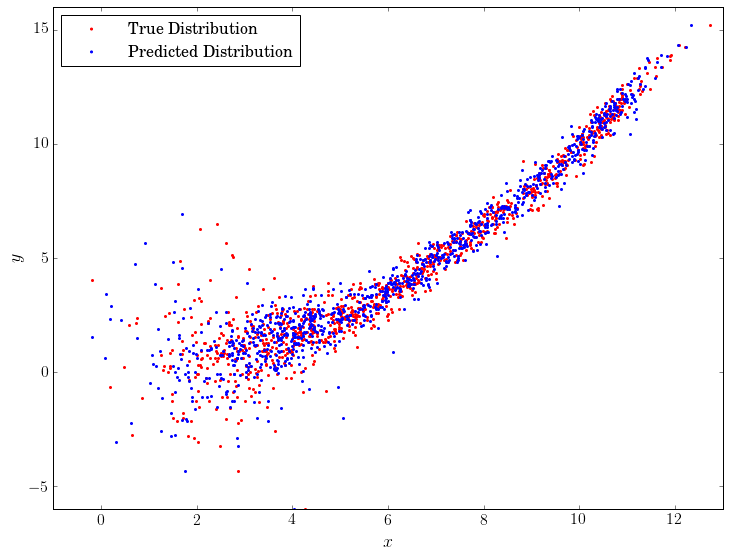

In [14]:
# Simulate a dataset:
true_sample = xdgmm.sample(1000)
true_x = true_sample[:,0]
y = true_sample[:,1]

# Predict x values given y values:
predicted_x = np.array([])
for this_y in y:
    # Specify y-conditioning to apply to P(x,y):
    on_this = np.array([np.nan,this_y])
    # Compute conditional PDF P(x|y):
    cond_gmm = xdgmm.condition(on_this)
    # Draw a sample x value from this PDF, and add it to the growing list
    predicted_x = np.append(predicted_x, cond_gmm.sample())

# Plot the two datasets, to compare the true x and the predicted x:
plot_conditional_predictions(y, true_x, predicted_x)